# 환경 설정

In [ ]:
# !pip install catboost

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from keras.utils import to_categorical
from sklearn.metrics import log_loss
# from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from lightgbm import early_stopping
from xgboost import XGBClassifier
from sklearn import metrics

from hyperopt import fmin, tpe, Trials
from hyperopt import STATUS_OK
from sklearn.svm import SVC
from hyperopt import hp
import pandas as pd
import numpy as np

# 데이터 전처리

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/iitp_mid_flight/data/train_prep.csv", index_col = 0)

In [ ]:
train = train.drop(columns=['ID', 'Cancelled'], axis=1)

In [ ]:
obj_col = ['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Airline']

for i in obj_col:
    le = LabelEncoder()
    le.fit(train[i].astype(str))
    train[i] = le.transform(train[i].astype(str))

In [ ]:
train = train.dropna()

In [ ]:
train['Delay'] = train['Delay'].map(lambda x : 0 if x=='Not_Delayed' else 1)

In [ ]:
def get_clf_eval(y_test, pred):
    confusion= confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print(f'정확도 : {accuracy:.4f}, 정밀도 : {precision:.4f}, 재현율 : {recall:.4f}, F1 : {f1:.4f}')

In [ ]:
X = train.iloc[:,:-1]
y = train.iloc[:,-1]

X_train, X_valid , y_train, y_valid = train_test_split(X, y, test_size = 0.2, stratify = y, random_state=42)

In [ ]:
numeric_cols = X_train.select_dtypes(exclude=['object']).columns

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_valid[numeric_cols] = scaler.transform(X_valid[numeric_cols])

In [ ]:
X_train.head()

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline
88102,1.163079,0.480879,0.982644,0.792988,0.0,-1.102284,-1.087320,0.597358,-0.371864,-0.455931,1.096892,-1.196906,-1.183142
879962,-0.565354,1.616872,0.414826,0.402083,0.0,-0.653838,-0.718214,0.403150,0.725103,0.817842,-0.714639,-0.102464,1.227133
630138,0.875007,0.594479,-1.025095,-0.839509,0.0,0.631708,0.714785,-1.150509,0.874690,0.934418,-1.296917,-0.226523,0.865591
524484,0.010790,-0.314315,-0.076583,0.151191,0.0,-1.700213,-1.613674,0.532622,-1.608446,-1.509066,-0.908732,0.125262,-0.580573
329528,0.875007,0.594479,-0.973373,-0.759095,0.0,0.083607,0.118031,0.273679,-1.807894,-1.678331,0.449917,-0.498435,0.865591


In [ ]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(174600, 13) (174600,)
(43650, 13) (43650,)


# RandomForest

In [ ]:
rf_model = RandomForestClassifier(n_estimators=5, max_depth=8, n_jobs=-1, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=5, n_jobs=-1, random_state=42)

In [ ]:
y_pred = rf_model.predict(X_valid)
get_clf_eval(y_valid, y_pred)

오차 행렬
[[35942     2]
 [ 7706     0]]
정확도 : 0.8234, 정밀도 : 0.0000, 재현율 : 0.0000, F1 : 0.0000


In [ ]:
rf_report = metrics.classification_report(y_valid, y_pred, zero_division=1)
print(rf_report)

              precision    recall  f1-score   support

           0       0.82      1.00      0.90     35944
           1       0.00      0.00      0.00      7706

    accuracy                           0.82     43650
   macro avg       0.41      0.50      0.45     43650
weighted avg       0.68      0.82      0.74     43650



# XGB Model

In [ ]:
xgb_model = XGBClassifier(learning_rate=0.01,
                          n_estimators=1000,
                          max_depth=8,
                          random_state=42)

In [ ]:
xgb_model.fit(X_train, y_train, early_stopping_rounds=50,
              eval_metric=['logloss'], eval_set=[(X_train, y_train), (X_valid, y_valid)])

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.47026	validation_1-logloss:0.47033
[1]	validation_0-logloss:0.46979	validation_1-logloss:0.46992
[2]	validation_0-logloss:0.46933	validation_1-logloss:0.46953
[3]	validation_0-logloss:0.46887	validation_1-logloss:0.46914
[4]	validation_0-logloss:0.46843	validation_1-logloss:0.46876
[5]	validation_0-logloss:0.46799	validation_1-logloss:0.46838
[6]	validation_0-logloss:0.46755	validation_1-logloss:0.46800
[7]	validation_0-logloss:0.46712	validation_1-logloss:0.46763
[8]	validation_0-logloss:0.46670	validation_1-logloss:0.46727
[9]	validation_0-logloss:0.46628	validation_1-logloss:0.46692
[10]	validation_0-logloss:0.46588	validation_1-logloss:0.46657
[11]	validation_0-logloss:0.46547	validation_1-logloss:0.46623
[12]	validation_0-logloss:0.46508	validation_1-logloss:0.46589
[13]	validation_0-logloss:0.46469	validation_1-logloss:0.46556
[14]	validation_0-logloss:0.46430	validation_1-logloss:0.46524
[15]	validation_0-logloss:0.46393	validation_1-logloss:0.46492
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred = xgb_model.predict(X_valid)
get_clf_eval(y_valid, y_pred)

오차 행렬
[[35875    69]
 [ 7608    98]]
정확도 : 0.8241, 정밀도 : 0.5868, 재현율 : 0.0127, F1 : 0.0249


In [ ]:
xgb_report = metrics.classification_report(y_valid, y_pred, zero_division=1)
print(xgb_report)

              precision    recall  f1-score   support

           0       0.83      1.00      0.90     35944
           1       0.59      0.01      0.02      7706

    accuracy                           0.82     43650
   macro avg       0.71      0.51      0.46     43650
weighted avg       0.78      0.82      0.75     43650



- Label 불균형의 영향으로 다른 평가지표에 비해 정확도만 높은 예측 모델이 되었다   
- 항공편의 실제 지연 여부를 제대로 예측해야 하므로 재현율 개선이 필요하다

In [ ]:
xgb_model.feature_importances_

array([0.08793497, 0.06394368, 0.17046417, 0.07126297, 0.        ,
       0.05963052, 0.09186201, 0.07927898, 0.06368655, 0.08364222,
       0.07810441, 0.06170309, 0.08848649], dtype=float32)

<ipython-input-18-f2423103d5c9>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ftr_top20, y = ftr_top20.index, palette='pastel')


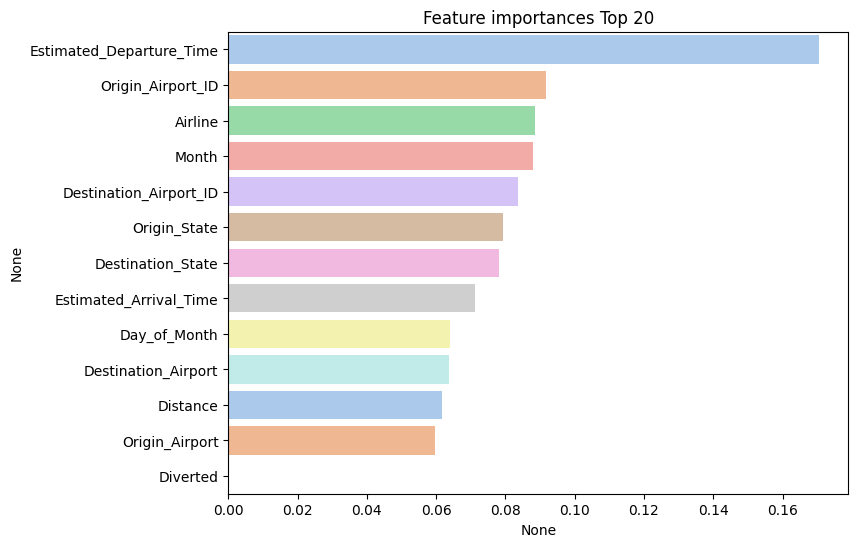

In [ ]:
ftr_importances_values = xgb_model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y = ftr_top20.index, palette='pastel')
plt.show()

# LightGBM

In [ ]:
X = train.iloc[:,:-1]
y = train.iloc[:,-1]

X_train, X_valid , y_train, y_valid = train_test_split(X, y, test_size = 0.2, stratify = y, random_state=42)

numeric_cols = X_train.select_dtypes(exclude=['object']).columns

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_valid[numeric_cols] = scaler.transform(X_valid[numeric_cols])

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(174600, 13) (174600,)
(43650, 13) (43650,)


In [ ]:
lgbm_model = LGBMClassifier(n_estimators=1000, num_leaves=64,
                          n_jobs=-1, boost_from_average=False, force_col_wise=True)

In [ ]:
lgbm_model.fit(X_train, y_train, callbacks=[early_stopping(stopping_rounds=50)],
              eval_metric=['logloss'], eval_set=[(X_train, y_train), (X_valid, y_valid)])

[LightGBM] [Info] Number of positive: 30823, number of negative: 143777
[LightGBM] [Info] Total Bins 1805
[LightGBM] [Info] Number of data points in the train set: 174600, number of used features: 12
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.417391	valid_1's binary_logloss: 0.438999


LGBMClassifier(boost_from_average=False, force_col_wise=True, n_estimators=1000,
               n_jobs=-1, num_leaves=64)

In [ ]:
y_pred = lgbm_model.predict(X_valid)
get_clf_eval(y_valid, y_pred)

오차 행렬
[[35866    78]
 [ 7597   109]]
정확도 : 0.8242, 정밀도 : 0.5829, 재현율 : 0.0141, F1 : 0.0276


In [ ]:
lgbm_report = metrics.classification_report(y_valid, y_pred, zero_division=1)
print(lgbm_report)

              precision    recall  f1-score   support

           0       0.83      1.00      0.90     35944
           1       0.58      0.01      0.03      7706

    accuracy                           0.82     43650
   macro avg       0.70      0.51      0.47     43650
weighted avg       0.78      0.82      0.75     43650



-> label 불균형으로 delay를 거의 예측하지 못한다

# Logistic Regression

In [ ]:
X = train.iloc[:,:-1]
y = train.iloc[:,-1]

X_train, X_valid , y_train, y_valid = train_test_split(X, y, test_size = 0.2, stratify = y, random_state=42)

numeric_cols = X_train.select_dtypes(exclude=['object']).columns

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_valid[numeric_cols] = scaler.transform(X_valid[numeric_cols])

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(174600, 13) (174600,)
(43650, 13) (43650,)


In [ ]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)

lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
y_pred = lr_model.predict(X_valid)
get_clf_eval(y_valid, y_pred)

오차 행렬
[[35944     0]
 [ 7706     0]]
정확도 : 0.8235, 정밀도 : 0.0000, 재현율 : 0.0000, F1 : 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
lr_report = metrics.classification_report(y_valid, y_pred, zero_division=1)
print(lr_report)

              precision    recall  f1-score   support

           0       0.82      1.00      0.90     35944
           1       1.00      0.00      0.00      7706

    accuracy                           0.82     43650
   macro avg       0.91      0.50      0.45     43650
weighted avg       0.85      0.82      0.74     43650



In [ ]:
lr_report = metrics.classification_report(y_valid, y_pred, zero_division=1)
print(lr_report)

              precision    recall  f1-score   support

           0       0.83      1.00      0.90     35944
           1       0.58      0.01      0.03      7706

    accuracy                           0.82     43650
   macro avg       0.70      0.51      0.47     43650
weighted avg       0.78      0.82      0.75     43650



# label 불균형 해결 1 : Over Sampling(SMOTE)

In [ ]:
X = train.iloc[:,:-1]
y = train.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)

numeric_cols = X_train.select_dtypes(exclude=['object']).columns

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_valid[numeric_cols] = scaler.transform(X_valid[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(157140, 13) (157140,)
(17460, 13) (17460,)
(43650, 13) (43650,)


In [ ]:
smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [ ]:
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 분포 : \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :  (157140, 13) (157140,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :  (258784, 13) (258784,)
SMOTE 적용 후 레이블 분포 : 
 Delay
1    129392
0    129392
Name: count, dtype: int64


## LogisticRegression

In [ ]:
lr_model = LogisticRegression(random_state=42, max_iter=1000, verbose=True,
                              penalty='l2', n_jobs=-1)

lr_model.fit(X_train_over, y_train_over)
y_pred = lr_model.predict(X_valid)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:
get_clf_eval(y_valid, y_pred)

오차 행렬
[[8120 6265]
 [1189 1886]]
정확도 : 0.5731, 정밀도 : 0.2314, 재현율 : 0.6133, F1 : 0.3360


In [ ]:
lr_report_over = metrics.classification_report(y_valid, y_pred, zero_division=1)
print(lr_report_over)

              precision    recall  f1-score   support

           0       0.87      0.56      0.69     14385
           1       0.23      0.61      0.34      3075

    accuracy                           0.57     17460
   macro avg       0.55      0.59      0.51     17460
weighted avg       0.76      0.57      0.62     17460



-> 정확도는 하락했지만 재현율이 상당히 개선되었다

## LightGBM

In [ ]:
lgbm_over_model = LGBMClassifier(n_estimators=1000, num_leaves=64,
                          n_jobs=-1, boost_from_average=False, force_col_wise=True)

In [ ]:
lgbm_over_model.fit(X_train, y_train, callbacks=[early_stopping(stopping_rounds=50)],
              eval_metric=['logloss'], eval_set=[(X_train, y_train), (X_valid, y_valid)])

y_pred = lgbm_over_model.predict(X_test)
get_clf_eval(y_test, y_pred)

lgbm_under_report = metrics.classification_report(y_test, y_pred, zero_division=1)
print(lgbm_under_report)

[LightGBM] [Info] Number of positive: 27748, number of negative: 129392
[LightGBM] [Info] Total Bins 1804
[LightGBM] [Info] Number of data points in the train set: 157140, number of used features: 12
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	training's binary_logloss: 0.42386	valid_1's binary_logloss: 0.440567
오차 행렬
[[35894    50]
 [ 7630    76]]
정확도 : 0.8241, 정밀도 : 0.6032, 재현율 : 0.0099, F1 : 0.0194
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     35944
           1       0.60      0.01      0.02      7706

    accuracy                           0.82     43650
   macro avg       0.71      0.50      0.46     43650
weighted avg       0.79      0.82      0.75     43650



## KNN

In [ ]:
knn = KNeighborsClassifier()

parameters = {'n_neighbors' : [5, 7, 9, 12]}
knn_grid = GridSearchCV(knn, param_grid=parameters, cv=3, refit=True)
knn_grid.fit(X_train_over, y_train_over)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5, 7, 9, 12]})

In [ ]:
scores_df = pd.DataFrame(knn_grid.cv_results_)
scores_df[['params', 'mean_test_score',
           'rank_test_score', 'split0_test_score',
           'split1_test_score', 'split2_test_score']]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,{'n_neighbors': 5},0.770467,1,0.761591,0.775214,0.774598
1,{'n_neighbors': 7},0.752036,2,0.738044,0.759189,0.758876
2,{'n_neighbors': 9},0.738150,3,0.720840,0.746930,0.746680
3,{'n_neighbors': 12},0.729901,4,0.708373,0.739293,0.742037


In [ ]:
y_pred = knn_grid.predict(X_valid)

In [ ]:
get_clf_eval(y_valid, y_pred)

오차 행렬
[[22728 13216]
 [ 4231  3475]]
정확도 : 0.6003, 정밀도 : 0.2082, 재현율 : 0.4509, F1 : 0.2849


In [ ]:
knn_report = metrics.classification_report(y_valid, y_pred, zero_division=1)
print(knn_report)

              precision    recall  f1-score   support

           0       0.84      0.63      0.72     35944
           1       0.21      0.45      0.28      7706

    accuracy                           0.60     43650
   macro avg       0.53      0.54      0.50     43650
weighted avg       0.73      0.60      0.65     43650



-> over sampling을 했지만 여전히 Delay 데이터가 적어서 재현율이 크게 개선되지 않았다

## XGBoost

In [ ]:
xgb_over_model = XGBClassifier(learning_rate=0.01,
                          n_estimators=1000,
                          max_depth=8,
                          random_state=42)

In [ ]:
xgb_over_model.fit(X_train_over, y_train_over, early_stopping_rounds=50,
              eval_metric=['logloss'], eval_set=[(X_train, y_train), (X_valid, y_valid)])

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.69155	validation_1-logloss:0.69157
[1]	validation_0-logloss:0.68997	validation_1-logloss:0.69003
[2]	validation_0-logloss:0.68843	validation_1-logloss:0.68851
[3]	validation_0-logloss:0.68691	validation_1-logloss:0.68702
[4]	validation_0-logloss:0.68531	validation_1-logloss:0.68545
[5]	validation_0-logloss:0.68374	validation_1-logloss:0.68390
[6]	validation_0-logloss:0.68228	validation_1-logloss:0.68246
[7]	validation_0-logloss:0.68085	validation_1-logloss:0.68107
[8]	validation_0-logloss:0.67942	validation_1-logloss:0.67966
[9]	validation_0-logloss:0.67794	validation_1-logloss:0.67821
[10]	validation_0-logloss:0.67648	validation_1-logloss:0.67677
[11]	validation_0-logloss:0.67516	validation_1-logloss:0.67548
[12]	validation_0-logloss:0.67374	validation_1-logloss:0.67408
[13]	validation_0-logloss:0.67246	validation_1-logloss:0.67284
[14]	validation_0-logloss:0.67117	validation_1-logloss:0.67156
[15]	validation_0-logloss:0.66994	validation_1-logloss:0.67036
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred = xgb_over_model.predict(X_valid)
get_clf_eval(y_valid, y_pred)

오차 행렬
[[35335   609]
 [ 7223   483]]
정확도 : 0.8206, 정밀도 : 0.4423, 재현율 : 0.0627, F1 : 0.1098


In [ ]:
xgb_over_report = metrics.classification_report(y_valid, y_pred, zero_division=1)
print(xgb_over_report)

              precision    recall  f1-score   support

           0       0.83      0.98      0.90     35944
           1       0.44      0.06      0.11      7706

    accuracy                           0.82     43650
   macro avg       0.64      0.52      0.51     43650
weighted avg       0.76      0.82      0.76     43650



- 재현율이 유의미하게 개선되지 않았다

## SVM

In [ ]:
svm = SVC(C=1, kernel='rbf', gamma=10, random_state=42)
svm.fit(X_train_over, y_train_over)

In [ ]:
y_pred = svm.predict(X_test)
get_clf_eval(y_test, y_pred)

In [ ]:
svm_report_under = metrics.classification_report(y_test, y_pred, zero_division=1)
print(svm_report_under)

              precision    recall  f1-score   support

           0       0.82      1.00      0.90     35944
           1       1.00      0.00      0.00      7706

    accuracy                           0.82     43650
   macro avg       0.91      0.50      0.45     43650
weighted avg       0.85      0.82      0.74     43650



# label 불균형 해결 2 : Under Sampling

In [ ]:
not_delayed_data = train[train['Delay'] == 0]
delayed_data = train[train['Delay'] == 1]

In [ ]:
under_not_delayed = not_delayed_data.sample(n=len(delayed_data), random_state=42)
under_data = pd.concat([delayed_data, under_not_delayed], axis=0)

In [ ]:
print(under_data['Delay'].value_counts())

Delay
1    38529
0    38529
Name: count, dtype: int64


In [ ]:
X = under_data.iloc[:,:-1]
y = under_data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state=42)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(55481, 13) (55481,)
(6165, 13) (6165,)
(15412, 13) (15412,)


In [ ]:
numeric_cols = X_train.select_dtypes(exclude=['object']).columns

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_valid[numeric_cols] = scaler.transform(X_valid[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(55481, 13) (55481,)
(6165, 13) (6165,)
(15412, 13) (15412,)


## Logistic Regression

In [ ]:
lr_model = LogisticRegression(random_state=42, max_iter=1000, verbose=True,
                              penalty='l2', n_jobs=-1)

lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_valid)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:
get_clf_eval(y_valid, y_pred)

오차 행렬
[[1697 1414]
 [1176 1878]]
정확도 : 0.5799, 정밀도 : 0.5705, 재현율 : 0.6149, F1 : 0.5919


In [ ]:
lr_report_over = metrics.classification_report(y_valid, y_pred, zero_division=1)
print(lr_report_over)

              precision    recall  f1-score   support

           0       0.59      0.55      0.57      3111
           1       0.57      0.61      0.59      3054

    accuracy                           0.58      6165
   macro avg       0.58      0.58      0.58      6165
weighted avg       0.58      0.58      0.58      6165



## LightGBM

In [ ]:
lgbm_under_model = LGBMClassifier(n_estimators=1000, num_leaves=64,
                          n_jobs=-1, boost_from_average=False, force_col_wise=True)

In [ ]:
lgbm_under_model.fit(X_train, y_train, callbacks=[early_stopping(stopping_rounds=50)],
              eval_metric=['logloss'], eval_set=[(X_train, y_train), (X_valid, y_valid)])

y_pred = lgbm_under_model.predict(X_test)
get_clf_eval(y_test, y_pred)

lgbm_under_report = metrics.classification_report(y_test, y_pred, zero_division=1)
print(lgbm_under_report)

[LightGBM] [Info] Number of positive: 27769, number of negative: 27712
[LightGBM] [Info] Total Bins 1802
[LightGBM] [Info] Number of data points in the train set: 55481, number of used features: 12
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.593364	valid_1's binary_logloss: 0.650798
오차 행렬
[[4772 2934]
 [3020 4686]]
정확도 : 0.6137, 정밀도 : 0.6150, 재현율 : 0.6081, F1 : 0.6115
              precision    recall  f1-score   support

           0       0.61      0.62      0.62      7706
           1       0.61      0.61      0.61      7706

    accuracy                           0.61     15412
   macro avg       0.61      0.61      0.61     15412
weighted avg       0.61      0.61      0.61     15412



## KNN

In [ ]:
knn = KNeighborsClassifier()

parameters = {'n_neighbors' : [5, 7, 9, 12]}
knn_grid = GridSearchCV(knn, param_grid=parameters, cv=3, refit=True)
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5, 7, 9, 12]})

In [ ]:
scores_df = pd.DataFrame(knn_grid.cv_results_)
scores_df[['params', 'mean_test_score',
           'rank_test_score', 'split0_test_score',
           'split1_test_score', 'split2_test_score']]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,{'n_neighbors': 5},0.555632,4,0.557748,0.551747,0.557400
1,{'n_neighbors': 7},0.559399,3,0.560722,0.559154,0.558319
2,{'n_neighbors': 9},0.562589,2,0.564616,0.562236,0.560915
3,{'n_neighbors': 12},0.565761,1,0.567103,0.564399,0.565782


In [ ]:
y_pred = knn_grid.predict(X_valid)
get_clf_eval(y_valid, y_pred)

knn_report_under = metrics.classification_report(y_valid, y_pred, zero_division=1)
print(knn_report_under)

오차 행렬
[[1994 1117]
 [1530 1524]]
정확도 : 0.5706, 정밀도 : 0.5771, 재현율 : 0.4990, F1 : 0.5352
              precision    recall  f1-score   support

           0       0.57      0.64      0.60      3111
           1       0.58      0.50      0.54      3054

    accuracy                           0.57      6165
   macro avg       0.57      0.57      0.57      6165
weighted avg       0.57      0.57      0.57      6165



## XGBoost

In [ ]:
xgb_model = XGBClassifier(learning_rate=0.01,
                          n_estimators=1000,
                          max_depth=8,
                          random_state=42)

In [ ]:
xgb_model.fit(X_train, y_train, early_stopping_rounds=50,
              eval_metric=['logloss'], eval_set=[(X_train, y_train), (X_valid, y_valid)])

[0]	validation_0-logloss:0.69234	validation_1-logloss:0.69256
[1]	validation_0-logloss:0.69154	validation_1-logloss:0.69197
[2]	validation_0-logloss:0.69076	validation_1-logloss:0.69139
[3]	validation_0-logloss:0.68998	validation_1-logloss:0.69082


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-logloss:0.68923	validation_1-logloss:0.69028
[5]	validation_0-logloss:0.68848	validation_1-logloss:0.68974
[6]	validation_0-logloss:0.68775	validation_1-logloss:0.68922
[7]	validation_0-logloss:0.68699	validation_1-logloss:0.68869
[8]	validation_0-logloss:0.68624	validation_1-logloss:0.68814
[9]	validation_0-logloss:0.68556	validation_1-logloss:0.68766
[10]	validation_0-logloss:0.68483	validation_1-logloss:0.68713
[11]	validation_0-logloss:0.68412	validation_1-logloss:0.68661
[12]	validation_0-logloss:0.68342	validation_1-logloss:0.68612
[13]	validation_0-logloss:0.68273	validation_1-logloss:0.68565
[14]	validation_0-logloss:0.68208	validation_1-logloss:0.68520
[15]	validation_0-logloss:0.68141	validation_1-logloss:0.68474
[16]	validation_0-logloss:0.68076	validation_1-logloss:0.68425
[17]	validation_0-logloss:0.68011	validation_1-logloss:0.68382
[18]	validation_0-logloss:0.67947	validation_1-logloss:0.68338
[19]	validation_0-logloss:0.67883	validation_1-logloss:0.6829

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred = xgb_model.predict(X_test)
get_clf_eval(y_test, y_pred)

오차 행렬
[[4799 2907]
 [3079 4627]]
정확도 : 0.6116, 정밀도 : 0.6141, 재현율 : 0.6004, F1 : 0.6072


In [ ]:
xgb_report_under = metrics.classification_report(y_test, y_pred, zero_division=1)
print(xgb_report_under)

              precision    recall  f1-score   support

           0       0.61      0.62      0.62      7706
           1       0.61      0.60      0.61      7706

    accuracy                           0.61     15412
   macro avg       0.61      0.61      0.61     15412
weighted avg       0.61      0.61      0.61     15412



## SVM

In [ ]:
svm = SVC(C=0.2, kernel='rbf', random_state=42)
svm.fit(X_train, y_train)

SVC(C=0.2, random_state=42)

In [ ]:
y_pred = svm.predict(X_valid)
get_clf_eval(y_valid, y_pred)

오차 행렬
[[4227 3479]
 [2954 4752]]
정확도 : 0.5826, 정밀도 : 0.5773, 재현율 : 0.6167, F1 : 0.5963


In [ ]:
svm_report_under = metrics.classification_report(y_valid, y_pred, zero_division=1)
print(svm_report_under)

              precision    recall  f1-score   support

           0       0.59      0.55      0.57      7706
           1       0.58      0.62      0.60      7706

    accuracy                           0.58     15412
   macro avg       0.58      0.58      0.58     15412
weighted avg       0.58      0.58      0.58     15412



# 하이퍼파라미터 튜닝 : GridSearch

## XGBoost

- 다른 모델보다 XGB 모델의 성능이 전반적으로 높으므로 XGB 모델을 채택해 하이퍼파라미터 튜닝을 진행했다

In [ ]:
grid_search = {'max_depth' : [2, 3, 4, 5],
               'learning_rate' : [0.01, 0.05, 0.1],
               'n_estimators': [100, 200, 300, 400, 500, 600]}

In [ ]:
xgb = XGBClassifier()
xgb_grid = GridSearchCV(estimator = xgb, param_grid = grid_search, cv = 5, verbose= 5, n_jobs = -1)

xgb_grid.fit(X_train, y_train)

In [ ]:
print(xgb_grid.best_params_)

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}


In [ ]:
y_pred = xgb_grid.predict(X_test)
get_clf_eval(y_test, y_pred)

오차 행렬
[[4811 2895]
 [3031 4675]]
정확도 : 0.6155, 정밀도 : 0.6176, 재현율 : 0.6067, F1 : 0.6121


In [ ]:
xgb_grid_report = metrics.classification_report(y_test, y_pred, zero_division=1)
print(xgb_grid_report)

              precision    recall  f1-score   support

           0       0.61      0.62      0.62      7706
           1       0.62      0.61      0.61      7706

    accuracy                           0.62     15412
   macro avg       0.62      0.62      0.62     15412
weighted avg       0.62      0.62      0.62     15412



## LightGBM

In [ ]:
grid_search = {'num_leaves': [30, 50, 70],
               'min_child_samples': [20, 30, 40],
               'learning_rate': [0.01, 0.05, 0.08],
               'n_estimators': [200, 300, 400]
                }

In [ ]:
lgbm = LGBMClassifier()

In [ ]:
lgbm_grid = GridSearchCV(estimator=lgbm, param_grid=grid_search,
                         cv=5, verbose= True, n_jobs=-1)

lgbm_grid.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


[LightGBM] [Info] Number of positive: 27769, number of negative: 27712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1738
[LightGBM] [Info] Number of data points in the train set: 55481, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500514 -> initscore=0.002055
[LightGBM] [Info] Start training from score 0.002055


GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.08],
                         'min_child_samples': [20, 30, 40],
                         'n_estimators': [200, 300, 400],
                         'num_leaves': [30, 50, 70]},
             verbose=True)

In [ ]:
print(lgbm_grid.best_params_)

{'learning_rate': 0.05, 'min_child_samples': 40, 'n_estimators': 300, 'num_leaves': 50}


In [ ]:
y_pred = lgbm_grid.predict(X_test)
get_clf_eval(y_test, y_pred)

오차 행렬
[[4794 2912]
 [3039 4667]]
정확도 : 0.6139, 정밀도 : 0.6158, 재현율 : 0.6056, F1 : 0.6107


In [ ]:
lgbm_grid_report = metrics.classification_report(y_test, y_pred, zero_division=1)
print(lgbm_grid_report)

              precision    recall  f1-score   support

           0       0.61      0.62      0.62      7706
           1       0.62      0.61      0.61      7706

    accuracy                           0.61     15412
   macro avg       0.61      0.61      0.61     15412
weighted avg       0.61      0.61      0.61     15412



# HyperOpt

## XGBoost

In [ ]:
not_delayed_data = train[train['Delay'] == 0]
delayed_data = train[train['Delay'] == 1]

under_not_delayed = not_delayed_data.sample(n=len(delayed_data), random_state=42)
under_data = pd.concat([delayed_data, under_not_delayed], axis=0)

X = under_data.iloc[:,:-1]
y = under_data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state=42)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_valid.shape, y_valid.shape)

(55481, 13) (55481,)
(15412, 13) (15412,)
(6165, 13) (6165,)


In [ ]:
search_space = {'max_depth': hp.quniform('max_depth', 5, 20, 1),
               'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1),
               'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
               'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)}

In [ ]:
def objective_func(search_space):
  xgb_clf = XGBClassifier(
      n_estimators = 100,
      max_depth = int(search_space['max_depth']),
      min_child_weight = int(search_space['min_child_weight']),
      learning_rate = search_space['learning_rate'],
      colsample_bytree = search_space['colsample_bytree'],
      eval_metric = 'logloss'
  )

  accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)

  return {
      'loss':(-1) * np.mean(accuracy),
      'status':STATUS_OK
  }

In [ ]:
trial_val = Trials()
best = fmin(fn = objective_func,
            space = search_space,
            algo = tpe.suggest,
            max_evals = 50,
            trials = trial_val
            )

best

100%|██████████| 50/50 [06:46<00:00,  8.12s/trial, best loss: -0.6128223960488214]


{'colsample_bytree': 0.6065789863309242,
 'learning_rate': 0.1962378163977927,
 'max_depth': 5.0,
 'min_child_weight': 2.0}

In [ ]:
xgb_opt = XGBClassifier(n_estimators = 400,
                        learning_rate = round(best['learning_rate'], 5),
                        max_depth = int(best['max_depth']),
                        min_child_weight = int(best['min_child_weight']),
                        colsample_bytree = round(best['colsample_bytree'], 5)
                        )

In [ ]:
evals = [(X_train, y_train), (X_valid, y_valid)]

xgb_opt.fit(X_train, y_train,
                early_stopping_rounds = 50,
                eval_metric = 'logloss',
                eval_set = evals,
                verbose = True
                )

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.68503	validation_1-logloss:0.68574
[1]	validation_0-logloss:0.67786	validation_1-logloss:0.67925
[2]	validation_0-logloss:0.67278	validation_1-logloss:0.67481
[3]	validation_0-logloss:0.66904	validation_1-logloss:0.67178
[4]	validation_0-logloss:0.66769	validation_1-logloss:0.67116
[5]	validation_0-logloss:0.66502	validation_1-logloss:0.66921
[6]	validation_0-logloss:0.66341	validation_1-logloss:0.66828
[7]	validation_0-logloss:0.66149	validation_1-logloss:0.66689
[8]	validation_0-logloss:0.65964	validation_1-logloss:0.66533
[9]	validation_0-logloss:0.65826	validation_1-logloss:0.66431
[10]	validation_0-logloss:0.65691	validation_1-logloss:0.66320
[11]	validation_0-logloss:0.65526	validation_1-logloss:0.66210
[12]	validation_0-logloss:0.65418	validation_1-logloss:0.66160
[13]	validation_0-logloss:0.65276	validation_1-logloss:0.66042
[14]	validation_0-logloss:0.65175	validation_1-logloss:0.65977
[15]	validation_0-logloss:0.65046	validation_1-logloss:0.65875
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.60658, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.19624, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
def get_clf_eval(y_test, pred):
    confusion= confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print(f'정확도 : {accuracy:.4f}, 정밀도 : {precision:.4f}, 재현율 : {recall:.4f}, F1 : {f1:.4f}')

In [ ]:
y_pred = xgb_opt.predict(X_test)
get_clf_eval(y_test, y_pred)

오차 행렬
[[4762 2944]
 [2993 4713]]
정확도 : 0.6148, 정밀도 : 0.6155, 재현율 : 0.6116, F1 : 0.6136


In [ ]:
xgb_opt_report = metrics.classification_report(y_test, y_pred, zero_division=1)
print(xgb_opt_report)

              precision    recall  f1-score   support

           0       0.61      0.62      0.62      7706
           1       0.62      0.61      0.61      7706

    accuracy                           0.61     15412
   macro avg       0.61      0.61      0.61     15412
weighted avg       0.61      0.61      0.61     15412



## LightGBM

In [ ]:
search_space = {'max_depth': hp.quniform('max_depth', 5, 20, 1),
               'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1),
               'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
               'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)}

In [ ]:
def objective_func(search_space):
  lgbm_clf = LGBMClassifier(
      n_estimators = 100,
      max_depth = int(search_space['max_depth']),
      min_child_weight = int(search_space['min_child_weight']),
      learning_rate = search_space['learning_rate'],
      colsample_bytree = search_space['colsample_bytree'],
      eval_metric = 'logloss'
  )

  accuracy = cross_val_score(lgbm_clf, X_train, y_train, scoring='accuracy', cv=3)

  return {
      'loss':(-1) * np.mean(accuracy),
      'status':STATUS_OK
  }

In [ ]:
trial_val = Trials()
best = fmin(fn = objective_func,
            space = search_space,
            algo = tpe.suggest,
            max_evals = 50,
            trials = trial_val
            )

best

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 18512, number of negative: 18475
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1722
[LightGBM] [Info] Number of data points in the train set: 36987, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500500 -> initscore=0.002001
[LightGBM] [Info] Start training from score 0.002001
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max

{'colsample_bytree': 0.6366936129224374,
 'learning_rate': 0.08533763078836704,
 'max_depth': 5.0,
 'min_child_weight': 2.0}

In [ ]:
lgbm_opt = LGBMClassifier(n_estimators = 400,
                        learning_rate = round(best['learning_rate'], 5),
                        max_depth = int(best['max_depth']),
                        min_child_weight = int(best['min_child_weight']),
                        colsample_bytree = round(best['colsample_bytree'], 5)
                        )

In [ ]:
evals = [(X_train, y_train), (X_valid, y_valid)]

lgbm_opt.fit(X_train, y_train,
                eval_metric = 'logloss',
                eval_set = evals
                )

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 27769, number of negative: 27712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1738
[LightGBM] [Info] Number of data points in the train set: 55481, number of used features: 12
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500514 -> initscore=0.002055
[LightGBM] [Info] Start training from score 0.002055
[LightGBM] [Warning] No further splits with positive g

LGBMClassifier(colsample_bytree=0.63669, learning_rate=0.08534, max_depth=5,
               min_child_weight=2, n_estimators=400)

In [ ]:
y_pred = lgbm_opt.predict(X_test)
get_clf_eval(y_test, y_pred)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
오차 행렬
[[4780 2926]
 [3006 4700]]
정확도 : 0.6151, 정밀도 : 0.6163, 재현율 : 0.6099, F1 : 0.6131


In [ ]:
lgbm_opt_report = metrics.classification_report(y_test, y_pred, zero_division=1)
print(lgbm_opt_report)

              precision    recall  f1-score   support

           0       0.61      0.62      0.62      7706
           1       0.62      0.61      0.61      7706

    accuracy                           0.62     15412
   macro avg       0.62      0.62      0.62     15412
weighted avg       0.62      0.62      0.62     15412



# CatBoost
- label이 없는 test data 사용으로 logloss만 구할 수 있었음
- 모델 비교에서 제외

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/iitp_mid_flight/data/train_prep.csv", index_col = 0)
test = pd.read_csv("/content/drive/MyDrive/iitp_mid_flight/data/test_prep.csv", index_col = 0)

train = train.drop(columns=['ID', 'Cancelled'], axis=1)
test = test.drop(columns=['ID', 'Cancelled'], axis=1)

train = train.dropna()
test = test.dropna()

In [ ]:
X_train = train.drop(['Delay'],axis=1)
y_train = train['Delay']

In [ ]:
# object형 변수는 cat_features에 추가
cat_features = [f for f in X_train.columns if X_train[f].dtype == 'object']

def column_index(df, cat_features):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, cat_features, sorter=sidx)]

cat_features_idx = column_index(X_train, cat_features)
print("Cat features are: %s" % [f for f in cat_features])
print(cat_features_idx)

Cat features are: ['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Airline']
[ 5  7  8 10 12]


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

In [ ]:
cat = CatBoostClassifier(n_estimators=1000, max_depth=8, random_seed=42, learning_rate =0.01, bootstrap_type ='Bayesian')
cat.fit(X_train, y_train, cat_features=cat_features, verbose=20)
test_predictions = cat.predict_proba(test)

0:	learn: 0.6879052	total: 108ms	remaining: 1m 48s
20:	learn: 0.6022691	total: 5.89s	remaining: 4m 34s
40:	learn: 0.5483402	total: 9.36s	remaining: 3m 38s
60:	learn: 0.5138663	total: 13.1s	remaining: 3m 21s
80:	learn: 0.4914444	total: 17s	remaining: 3m 13s
100:	learn: 0.4768733	total: 22.3s	remaining: 3m 18s
120:	learn: 0.4671896	total: 26.1s	remaining: 3m 9s
140:	learn: 0.4604680	total: 30.2s	remaining: 3m 4s
160:	learn: 0.4560317	total: 36.2s	remaining: 3m 8s
180:	learn: 0.4528324	total: 40s	remaining: 3m 1s
200:	learn: 0.4503291	total: 44s	remaining: 2m 55s
220:	learn: 0.4485374	total: 49.8s	remaining: 2m 55s
240:	learn: 0.4471415	total: 53.7s	remaining: 2m 49s
260:	learn: 0.4458552	total: 58s	remaining: 2m 44s
280:	learn: 0.4448676	total: 1m 4s	remaining: 2m 44s
300:	learn: 0.4439368	total: 1m 9s	remaining: 2m 40s
320:	learn: 0.4431736	total: 1m 13s	remaining: 2m 35s
340:	learn: 0.4425402	total: 1m 20s	remaining: 2m 34s
360:	learn: 0.4419295	total: 1m 24s	remaining: 2m 29s
380:	lea